In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# UPLOAD DATASET

In [308]:
data = pd.read_csv("tyres_train.csv", sep = ",")

data.head(10)

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0
5,20.042,38,0,0.04,0.01,-0.20,2,1,160.5,0,0,0,5.96,NaN,1,0
6,21.172,33,1,0.39,0.01,-2.28,0,0,470.0,3,0,0,6.47,NaN,1,0
7,16.706,32,0,0.62,0.05,-3.96,3,1,148.5,7,2,0,5.39,NaN,1,0
8,17.616,25,1,0.16,0.01,-6.88,0,1,103.5,8,0,1,5.32,63.6,1,0
9,17.370,34,0,0.27,0.01,-1.28,2,0,345.5,5,2,0,6.31,NaN,0,0


# DATA OBSERVATION AND PREPARATION

In [309]:
data.dtypes
# categorical variables are no "object" type

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object

In [310]:
data.isnull().sum()
# the variable "diameter" is almost empty --> impossible to proceed with substitution

vulc                  0
perc_nat_rubber       0
wiring_strength       0
weather               0
perc_imp              0
temperature           0
tread_type            0
tyre_season           0
elevation             0
month                 0
tread_depth           0
tyre_quality          0
perc_exp_comp         0
diameter           2110
add_layers            0
failure               0
dtype: int64

In [311]:
#dropping all column "diameter"
d="diameter"
data_dropped = data.drop(columns=d)

data_dropped.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,1,0


In [312]:
data_dropped.isnull().sum()
# no more NaN observations

vulc               0
perc_nat_rubber    0
wiring_strength    0
weather            0
perc_imp           0
temperature        0
tread_type         0
tyre_season        0
elevation          0
month              0
tread_depth        0
tyre_quality       0
perc_exp_comp      0
add_layers         0
failure            0
dtype: int64

failure
0    1992
1    1008
dtype: int64


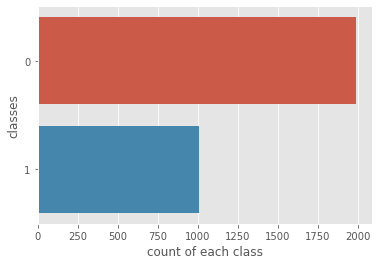

In [313]:
print(data_dropped.groupby('failure').size())

%matplotlib inline
plt.style.use('ggplot')

#Visualize Class Counts
sns.countplot(y=data_dropped.failure ,data=data_dropped)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()
# the dataset is unbalanced --> we will try to perform oversampling on the training set

## Categorical variables

In [321]:
selection_categorical=['tread_type', 'tyre_season','month', 'tread_depth', 'wiring_strength', 'tyre_quality',
       'add_layers']
data_categorical=data_dropped[selection_categorical]
data_categorical.head()

,tread_type,tyre_season,month,tread_depth,wiring_strength,tyre_quality,add_layers
0,0,1,8,0,1,1,1
1,2,0,11,1,1,0,1
2,0,0,0,1,1,0,1
3,1,0,7,3,1,1,1
4,0,1,2,2,2,0,1


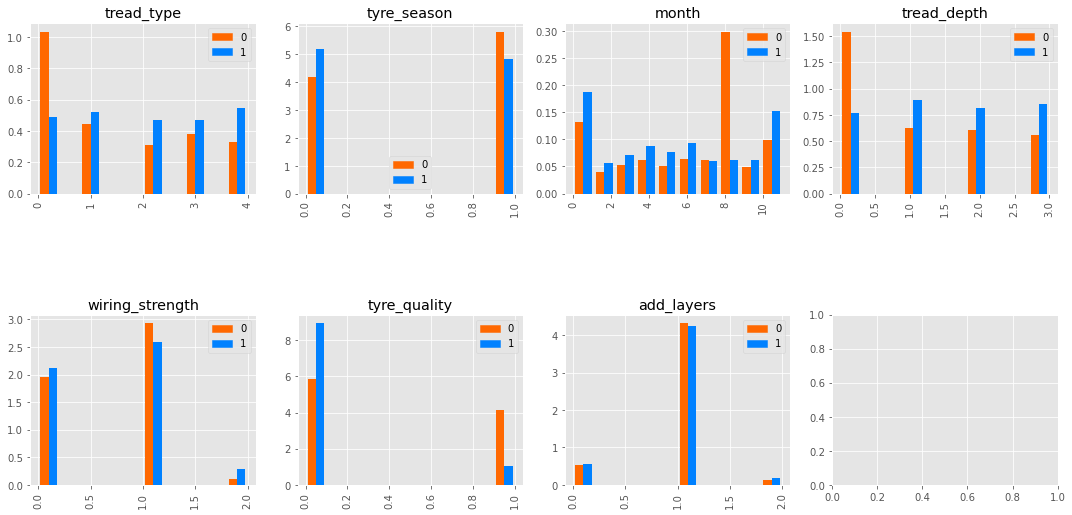

In [322]:
# Visualize categorical variables
data_0=data_categorical[data_dropped['failure']==0] # records wih target==0
data_1=data_categorical[data_dropped['failure']==1] # records wih target==1

cmap = plt.get_cmap('jet')
col=[cmap(0.8),cmap(0.25)]
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in data_categorical.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([data_0[x],data_1[x]],density=True,color=col)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    handles = [Rectangle((0,0),1,1,color=c)for c in col]
    labels= ["0","1"]
    plt.legend(handles, labels)
    i+=1
plt.show()

In [323]:
# add_layers has the same distibution on target 0 and 1 --> we eliminate it because not important for the analysis
ad="add_layers"
data_categorical = data_categorical.drop(columns=ad)
selection_categorical = ['tread_type', 'tyre_season', 'tread_depth','month', 'wiring_strength', 'tyre_quality']

### Create dummies with the OneHotEncoder method

In [324]:
from sklearn.preprocessing import OneHotEncoder
encod = OneHotEncoder(handle_unknown='ignore')

data_dummies=pd.DataFrame()
for i in range(len(selection_categorical)):
    encod.fit(data_dropped[[selection_categorical[i]]].astype(str))
    dummies = encod.transform(data_dropped[[selection_categorical[i]]].astype(str)).toarray()
    for k in range(len(encod.categories_[0])):
        encod.categories_[0][k]=selection_categorical[i]+"_"+str(encod.categories_[0][k])
    data_dummies=pd.concat([data_dummies,pd.DataFrame(dummies,columns=encod.categories_[0])],axis=1)
    
data_dummies.head()

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,month_5,month_6,month_7,month_8,month_9,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Numerical Variables

In [325]:
selection_numerical=['vulc', 'perc_nat_rubber', 'weather', 'perc_imp', 'temperature', 'elevation',
       'perc_exp_comp','failure']
data_numerical=data_dropped[selection_numerical]
data_numerical.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,failure
0,17.990,26,0.16,0.01,-8.12,332.5,5.13,0
1,20.704,36,0.30,0.01,-4.52,328.0,6.15,0
2,19.156,34,0.30,0.01,-1.08,247.0,6.36,0
3,16.802,35,0.19,0.02,7.44,408.0,6.62,0
4,17.140,23,0.39,0.01,30.52,308.0,6.15,0


(1992, 8)
(1008, 8)


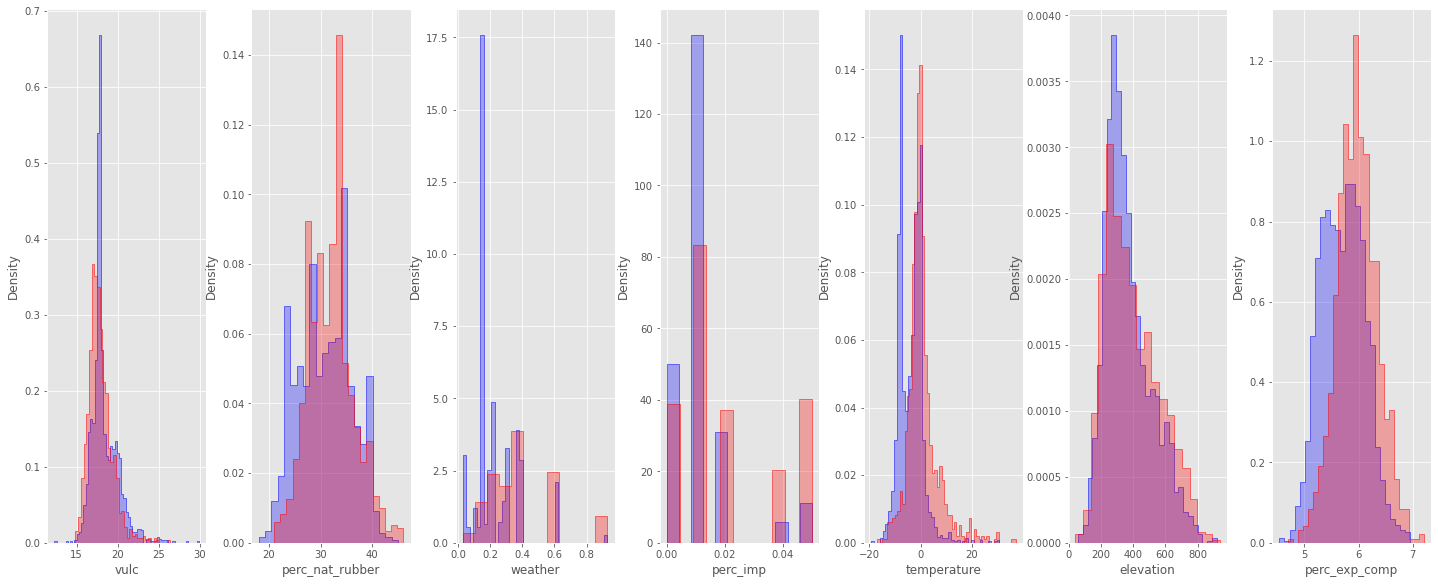

In [326]:
# Visualize numerical variables
X0 = data_numerical[data_numerical['failure']==0]
X1 = data_numerical[data_numerical['failure']==1]
print(X0.shape)
print(X1.shape)
fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(20,8))
fig.tight_layout()

data_num = data_numerical.iloc[:,0:-1]

for i, ax in zip(range(data_num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()


In [327]:
# elevation has the same distibution on target 0 and 1 --> we eliminate it because not important for the analysis
e="elevation"
data_numerical = data_numerical.drop(columns=e)

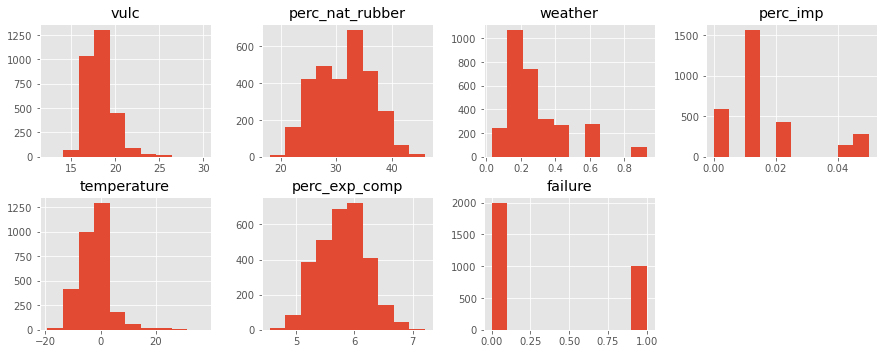

In [328]:
data_hist=data_numerical.hist(layout=(4,4), figsize=(15,12))
# no exponential variable to normalize

<AxesSubplot:>

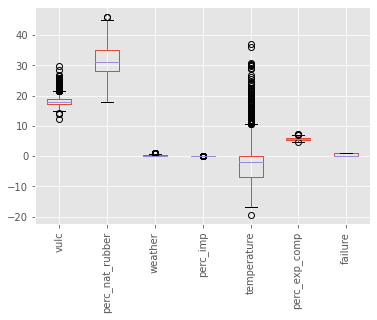

In [329]:
data_numerical.boxplot(rot=90)
# the scale of numerical variables is too different --> we will scale the train set and apply the same scaler on the test set

In [330]:
# Create final dataset with all modifications and target variable included
#print(K)

df=pd.concat([data_dummies,data_numerical],axis=1)

#df.drop(K,axis=0,inplace=True)

df['failure']=data_dropped['failure']


df.tail()

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,wiring_strength_2,tyre_quality_0,tyre_quality_1,vulc,perc_nat_rubber,weather,perc_imp,temperature,perc_exp_comp,failure
2995,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,17.818,29,0.39,0.01,7.28,5.68,1
2996,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,17.076,30,0.22,0.00,-1.44,5.81,1
2997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,16.170,33,0.39,0.01,-3.44,5.57,0
2998,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,18.872,37,0.03,0.00,-0.76,5.89,0
2999,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,20.272,33,0.06,0.00,2.80,6.00,0


# Creation of Train and Test Sets

In [331]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1] #[-1]]

In [332]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, 
                                                    test_size =0.25, 
                                                    #shuffle is set True by default,
                                                    stratify=y, #preserve target proportions 
                                                    random_state= 42) 

print(X_train1.shape, X_test1.shape)

(2250, 34) (750, 34)


In [333]:
# we have to scale the numerical variables of the train set --> then we apply the same scaler to the numerical variables of the test set
numerical=['vulc','perc_nat_rubber', 'weather', 'perc_imp', 'temperature', 'perc_exp_comp']


independent_variablesA=X_train1[numerical] #no target
independent_variablesB=X_test1[numerical] #no target

scaler_train = StandardScaler().fit(independent_variablesA) 
scaled_train = pd.DataFrame(scaler_train.transform(independent_variablesA))
scaled_train.columns = independent_variablesA.columns

scaled_test = pd.DataFrame(scaler_train.transform(independent_variablesB))
scaled_test.columns = independent_variablesB.columns
print(scaled_test.shape, scaled_train.shape)
scaled_test.head(10)

(750, 6) (2250, 6)


,vulc,perc_nat_rubber,weather,perc_imp,temperature,perc_exp_comp
0,0.450525,0.972207,-0.817311,-0.309506,-0.108239,0.123339
1,-1.361552,0.771301,-0.322349,-1.023751,0.405495,1.050411
2,-0.271807,-0.032324,-0.322349,-1.023751,0.197225,0.391702
3,-0.872916,0.369489,-0.322349,-1.023751,0.211109,-0.901320
4,0.834185,0.972207,-0.927303,-1.023751,0.870633,0.025752
5,-0.896661,0.369489,3.582354,1.833229,2.439606,1.587137
6,-0.876665,-1.237760,-0.377345,-1.023751,-0.129066,1.269980
7,-0.451765,-0.835948,-0.377345,-1.023751,-0.476184,0.416098
8,-0.366784,-0.233230,0.502588,0.404739,-0.024931,0.147735
9,1.362812,-0.434136,-0.377345,-1.023751,-0.941322,0.830841


<AxesSubplot:>

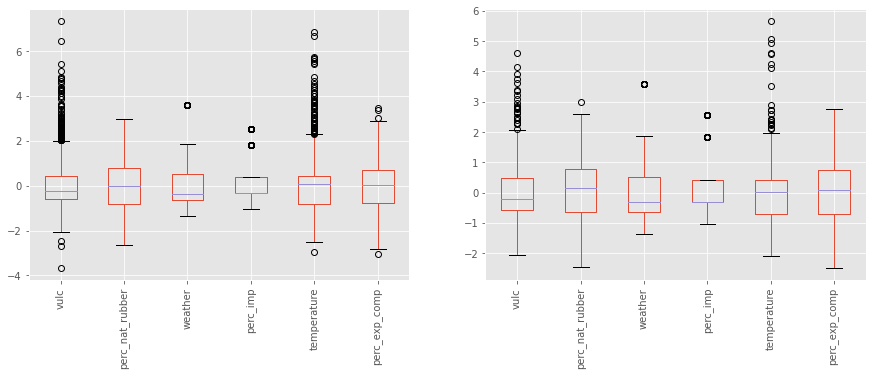

In [334]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

scaled_train.boxplot(rot=90,ax=axes[0])
scaled_test.boxplot(rot=90,ax=axes[1])
# the two sets are scaled correctly

In [335]:
# subsitute original numerical variables with scaled numerical variables

scaled_train.index= independent_variablesA.index
scaled_test.index= independent_variablesB.index

train_dropped = X_train1.drop(columns=numerical)
test_dropped = X_test1.drop(columns=numerical)
print(test_dropped.shape, train_dropped.shape)

Xtrain2=pd.concat([train_dropped,scaled_train],axis=1)
Xtest2=pd.concat([test_dropped,scaled_test],axis=1)


(750, 28) (2250, 28)


In [336]:
# check correct substitution
print(Xtest2.isnull().sum(), Xtrain2.isnull().sum())

tread_type_0         0
tread_type_1         0
tread_type_2         0
tread_type_3         0
tread_type_4         0
tyre_season_0        0
tyre_season_1        0
tread_depth_0        0
tread_depth_1        0
tread_depth_2        0
tread_depth_3        0
month_0              0
month_1              0
month_10             0
month_11             0
month_2              0
month_3              0
month_4              0
month_5              0
month_6              0
month_7              0
month_8              0
month_9              0
wiring_strength_0    0
wiring_strength_1    0
wiring_strength_2    0
tyre_quality_0       0
tyre_quality_1       0
vulc                 0
perc_nat_rubber      0
weather              0
perc_imp             0
temperature          0
perc_exp_comp        0
dtype: int64 tread_type_0         0
tread_type_1         0
tread_type_2         0
tread_type_3         0
tread_type_4         0
tyre_season_0        0
tyre_season_1        0
tread_depth_0        0
tread_depth_1        

In [337]:
# create new scaled datasets
df_train=pd.concat([Xtrain2,y_train1],axis=1)
df_test=pd.concat([Xtest2,y_test1], axis=1)

df_test.head(10)

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,wiring_strength_2,tyre_quality_0,tyre_quality_1,vulc,perc_nat_rubber,weather,perc_imp,temperature,perc_exp_comp,failure
2654,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.450525,0.972207,-0.817311,-0.309506,-0.108239,0.123339,0
2056,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-1.361552,0.771301,-0.322349,-1.023751,0.405495,1.050411,0
1161,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-0.271807,-0.032324,-0.322349,-1.023751,0.197225,0.391702,0
1699,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-0.872916,0.369489,-0.322349,-1.023751,0.211109,-0.901320,0
2008,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.834185,0.972207,-0.927303,-1.023751,0.870633,0.025752,0
105,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,-0.896661,0.369489,3.582354,1.833229,2.439606,1.587137,1
2380,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,-0.876665,-1.237760,-0.377345,-1.023751,-0.129066,1.269980,1
2564,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.451765,-0.835948,-0.377345,-1.023751,-0.476184,0.416098,0
1070,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-0.366784,-0.233230,0.502588,0.404739,-0.024931,0.147735,0
1709,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.362812,-0.434136,-0.377345,-1.023751,-0.941322,0.830841,0


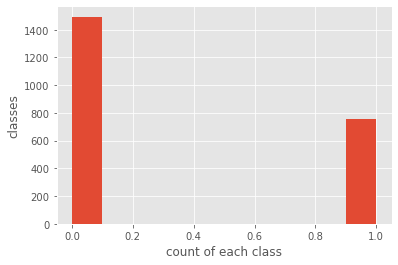

0    1494
1     756
Name: failure, dtype: int64

In [338]:
plt.hist(y_train1)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()
df_train.failure.value_counts()
# the dataset is unbalanced --> we can try to perform oversampling on target 1 to see if the F1 score gets better during identificaiton of the model

In [340]:
#resample train set
df_majority = df_train[df_train.failure==0]
df_minority = df_train[df_train.failure==1] 
print(df_majority.shape[0],df_minority.shape[0])

df_minority_overs = resample(df_minority, 
                                replace=True,
                                n_samples=1200,     
                                random_state=42)  

df_overs_train = pd.concat([df_minority_overs, df_majority])

df_overs_train.failure.value_counts()


1494 756


0    1494
1    1200
Name: failure, dtype: int64

In [271]:
#from sklearn.utils import shuffle
#df_oversampled_train = shuffle(df_oversampled_train)

In [342]:
#Separate X and y on the new DataFrames
# Dataframes with oversample
X2_train=df_overs_train.iloc[:,0:-1]
y2_train=df_overs_train.iloc[:,-1]

#DataFrames without oversample
X_train=df_train.iloc[:,0:-1]
y_train=df_train.iloc[:,-1]

X_test = df_test.iloc[:,0:-1]
y_test = df_test.iloc[:,-1]

print(X2_train.shape,X_train.shape,X_test.shape)

(2694, 34) (2250, 34) (750, 34)


# Models 

## Needed functions 

In [343]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [344]:
def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred)))
    print("")
    print(confusion_matrix(y_test, y_pred))
 

In [345]:
def hyperp_search_over(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X2_train, y2_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X2_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y2_train, y_pred_train), f1_score(y_test, y_pred)))
    print("")
    print(confusion_matrix(y_test, y_pred))
 

In [346]:
def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test)

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)

## Research of the best model

### TREE

In [347]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['gini','entropy'], 
              'max_depth': [2,3,4],
              'min_samples_split': [2,4,6,8,12,16,18,20],
              'min_samples_leaf': [4,6,8,12,16,18,20]}

In [348]:
hyperp_search(classifier,parameters)

f1_train: 0.548137 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 2}
f1         train 0.539   test 0.529

[[450  48]
 [144 108]]


In [349]:
hyperp_search_over(classifier,parameters)

f1_train: 0.719355 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
f1         train 0.739   test 0.612

[[312 186]
 [ 59 193]]


In [350]:
model_Tree= DecisionTreeClassifier(criterion= 'gini', max_depth= 4, min_samples_leaf= 16, min_samples_split= 2)

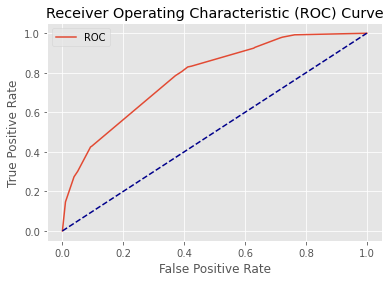

AUC: 0.78


In [351]:
#curva ROC
fpr1,tpr1=roc(model_Tree,X_train,y_train,X_test,y_test)

#### Plotting tree

In [352]:
from sklearn import tree
r = tree.export_text(model_Tree,feature_names=X_test.columns.tolist(),max_depth = 6 )
print(r)

|--- weather <= -0.43
|   |--- month_8 <= 0.50
|   |   |--- temperature <= 0.58
|   |   |   |--- weather <= -1.23
|   |   |   |   |--- class: 0
|   |   |   |--- weather >  -1.23
|   |   |   |   |--- class: 0
|   |   |--- temperature >  0.58
|   |   |   |--- perc_imp <= -0.67
|   |   |   |   |--- class: 0
|   |   |   |--- perc_imp >  -0.67
|   |   |   |   |--- class: 1
|   |--- month_8 >  0.50
|   |   |--- temperature <= 0.04
|   |   |   |--- tyre_season_0 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- tyre_season_0 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- temperature >  0.04
|   |   |   |--- class: 0
|--- weather >  -0.43
|   |--- temperature <= 0.57
|   |   |--- vulc <= 0.92
|   |   |   |--- weather <= 1.25
|   |   |   |   |--- class: 0
|   |   |   |--- weather >  1.25
|   |   |   |   |--- class: 1
|   |   |--- vulc >  0.92
|   |   |   |--- perc_nat_rubber <= -0.13
|   |   |   |   |--- class: 0
|   |   |   |--- perc_nat_rubber >  -0.13
|   |   |   |   |--- class: 0
|

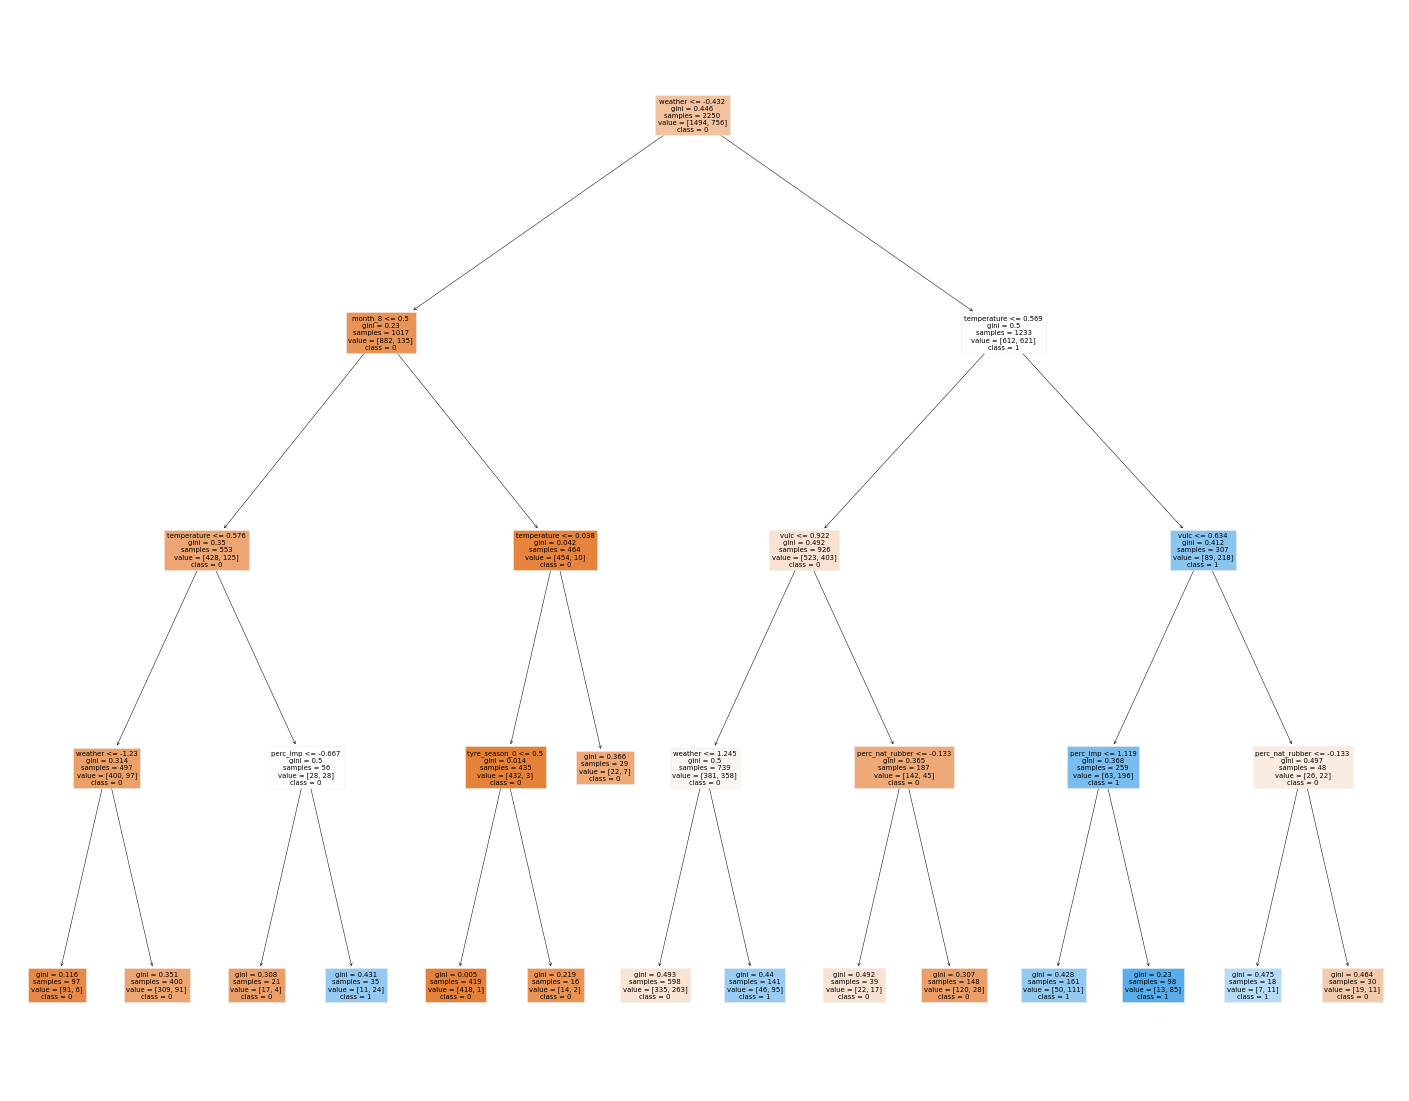

In [353]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_Tree, 
                   feature_names=X_test.columns.tolist(),  
                   class_names=['0','1'],
                   filled=True)

### KNN

In [354]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(50,120,2)}


In [355]:
hyperp_search(classifier,parameters)

f1_train: 0.536147 using {'n_neighbors': 56}
f1         train 0.561   test 0.562

[[438  60]
 [130 122]]


In [356]:
hyperp_search_over(classifier,parameters)

f1_train: 0.703663 using {'n_neighbors': 78}
f1         train 0.718   test 0.591

[[352 146]
 [ 85 167]]


In [357]:
model_knn = KNeighborsClassifier(n_neighbors=56)

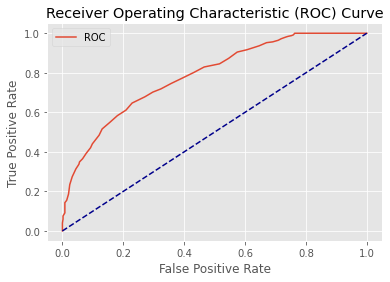

AUC: 0.79


In [359]:
#curva ROC
fpr2,tpr2=roc(model_knn,X_train,y_train,X_test,y_test)

### NAYVE BAYES

In [360]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred_train=model.predict(X_train)

y_pred=model.predict(X_test)

from sklearn.metrics import f1_score
print("f1_train: ", f1_score(y_train, y_pred_train))


print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_train:  0.5963114754098361
f1_test:  0.5771604938271605
[[289 209]
 [ 65 187]]
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       498
           1       0.47      0.74      0.58       252

    accuracy                           0.63       750
   macro avg       0.64      0.66      0.63       750
weighted avg       0.70      0.63      0.64       750



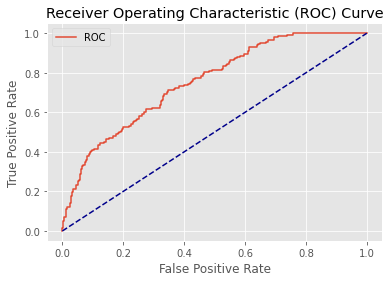

AUC: 0.75


In [361]:
#curva ROC
fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test)

### LOGISTIC REGRESSION

In [364]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "penalty":['l2','none'], "max_iter":[500,1000,10000] }

In [365]:
hyperp_search(classifier,parameters)

f1_train: 0.572431 using {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
f1         train 0.586   test 0.588

[[438  60]
 [122 130]]


In [366]:
model_Log = LogisticRegression(C=1, max_iter=500,penalty='l2')

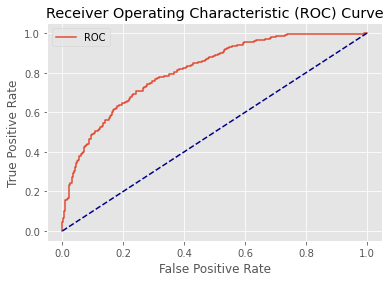

AUC: 0.81


In [367]:
#curva ROC
fpr4,tpr4=roc(model_Log,X_train,y_train,X_test,y_test)

### SVM

In [390]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','rbf','poly','sigmoid'], "C":[0.001,0.005,0.009],"gamma":[0.01,0.1,1], "degree":[1,2,3,4]}


In [391]:
hyperp_search(classifier,parameters)

f1_train: 0.522453 using {'C': 0.009, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
f1         train 0.598   test 0.522

[[444  54]
 [144 108]]


In [393]:
model = SVC(C=0.009, kernel='poly',degree=2,gamma=1,probability=True)

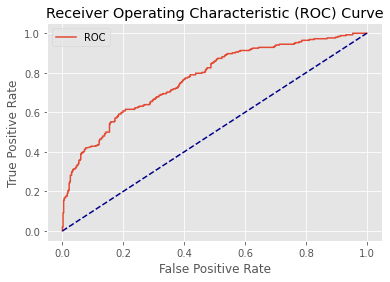

AUC: 0.77


In [394]:
fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test)

### NEURAL NETWORK

In [395]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(7,5,3,2),(7,5,3),(10, 5),(10, 5,2)],  "max_iter": [1000,5000,10000], "alpha": [0.001,0.009,0.1,0.9,1]}


In [396]:
hyperp_search(classifier,parameters)

f1_train: 0.613959 using {'alpha': 0.9, 'hidden_layer_sizes': (10, 5, 2), 'max_iter': 5000}
f1         train 0.681   test 0.593

[[418  80]
 [112 140]]


In [397]:
model_MLP=MLPClassifier(hidden_layer_sizes=(10,5,2), alpha=0.09, max_iter=5000)


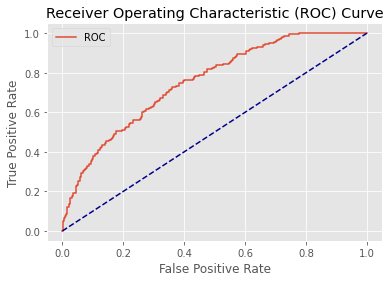

AUC: 0.75


In [398]:
#curva ROC
fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)

### RANDOM FOREST

In [405]:
from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' :     np.arange(2,8,1),
              'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(2,5,1), 
              'min_samples_split': np.arange(4,18,1),
              'min_samples_leaf' : np.arange(4,18,1),
              'class_weight' : ["balanced"]
             };



In [406]:
hyperp_search(classifier,parameters)

f1_train: 0.645431 using {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 6}
f1         train 0.649   test 0.601

[[256 242]
 [ 40 212]]


In [401]:
model_RandomForest=RandomForestClassifier(class_weight= 'balanced', criterion='entropy', max_depth=4,min_samples_leaf = 12, min_samples_split= 4, n_estimators= 7)


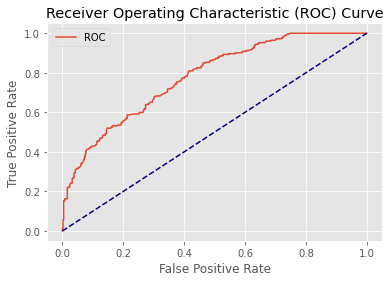

AUC: 0.78


In [402]:
#curva ROC
fpr7,tpr7=roc(model_RandomForest,X_train,y_train,X_test,y_test)

# CHOICE OF THE MODEL